In [24]:
import os
import nbimporter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
from DataParserforCNN import read_class
from StrokeRemoval import stroke_removal
import hull
import cv2
# from DeformImage import *
from keras.utils import Sequence
from random import randint
from albumentations import Rotate, Flip


%matplotlib inline

In [31]:
class_array = read_class()
base_path = '/Volumes/JS/QuickDraw/train_simplified/'
airplane = pd.read_csv(base_path + 'airplane.csv', nrows=25)

In [65]:
def mls_rigid_deformation_inv(image, p, q, alpha=1.0, density=1.0):
    ''' Rigid inverse deformation
    ### Params:
        * image - ndarray: original image
        * p - ndarray: an array with size [n, 2], original control points
        * q - ndarray: an array with size [n, 2], final control points
        * alpha - float: parameter used by weights
        * density - float: density of the grids
    ### Return:
        A deformed image.
    '''
    height = image.shape[0]
    width = image.shape[1]
    # Change (x, y) to (row, col)
    q = q[:, [1, 0]]
    p = p[:, [1, 0]]

    # Make grids on the original image
    gridX = np.linspace(0, width, num=int(width*density), endpoint=False)
    gridY = np.linspace(0, height, num=int(height*density), endpoint=False)
    vy, vx = np.meshgrid(gridX, gridY)
    grow = vx.shape[0]  # grid rows
    gcol = vx.shape[1]  # grid cols
    ctrls = p.shape[0]  # control points

    # Compute
    reshaped_p = p.reshape(ctrls, 2, 1, 1)                                              # [ctrls, 2, 1, 1]
    reshaped_q = q.reshape((ctrls, 2, 1, 1))                                            # [ctrls, 2, 1, 1]
    reshaped_v = np.vstack((vx.reshape(1, grow, gcol), vy.reshape(1, grow, gcol)))      # [2, grow, gcol]
    
    print(np.sum((reshaped_p - reshaped_v) ** 2, axis=1).shape)
    
    w = 1.0 / np.sum((reshaped_p - reshaped_v) ** 2, axis=1)**alpha                     # [ctrls, grow, gcol]
    w[w == np.inf] = 2**31 - 1
    pstar = np.sum(w * reshaped_p.transpose(1, 0, 2, 3), axis=1) / np.sum(w, axis=0)    # [2, grow, gcol]
    phat = reshaped_p - pstar                                                           # [ctrls, 2, grow, gcol]
    qstar = np.sum(w * reshaped_q.transpose(1, 0, 2, 3), axis=1) / np.sum(w, axis=0)    # [2, grow, gcol]
    qhat = reshaped_q - qstar                                                           # [ctrls, 2, grow, gcol]
    reshaped_phat1 = phat.reshape(ctrls, 1, 2, grow, gcol)                              # [ctrls, 1, 2, grow, gcol]
    reshaped_phat2 = phat.reshape(ctrls, 2, 1, grow, gcol)                              # [ctrls, 2, 1, grow, gcol]
    reshaped_qhat = qhat.reshape(ctrls, 1, 2, grow, gcol)                               # [ctrls, 1, 2, grow, gcol]
    reshaped_w = w.reshape(ctrls, 1, 1, grow, gcol)                                     # [ctrls, 1, 1, grow, gcol]

    mu = np.sum(np.matmul(reshaped_w.transpose(0, 3, 4, 1, 2) * 
                          reshaped_phat1.transpose(0, 3, 4, 1, 2), 
                          reshaped_phat2.transpose(0, 3, 4, 1, 2)), axis=0)             # [grow, gcol, 1, 1]
    reshaped_mu = mu.reshape(1, grow, gcol)                                             # [1, grow, gcol]
    neg_phat_verti = phat[:, [1, 0],...]                                                # [ctrls, 2, grow, gcol]
    neg_phat_verti[:, 1,...] = -neg_phat_verti[:, 1,...]                                
    reshaped_neg_phat_verti = neg_phat_verti.reshape(ctrls, 1, 2, grow, gcol)           # [ctrls, 1, 2, grow, gcol]
    mul_right = np.concatenate((reshaped_phat1, reshaped_neg_phat_verti), axis=1)       # [ctrls, 2, 2, grow, gcol]
    mul_left = reshaped_qhat * reshaped_w                                               # [ctrls, 1, 2, grow, gcol]
    Delta = np.sum(np.matmul(mul_left.transpose(0, 3, 4, 1, 2), 
                             mul_right.transpose(0, 3, 4, 1, 2)), 
                   axis=0).transpose(0, 1, 3, 2)                                        # [grow, gcol, 2, 1]
    Delta_verti = Delta[...,[1, 0],:]                                                   # [grow, gcol, 2, 1]
    Delta_verti[...,0,:] = -Delta_verti[...,0,:]
    B = np.concatenate((Delta, Delta_verti), axis=3)                                    # [grow, gcol, 2, 2]
    try:
        inv_B = np.linalg.inv(B)                                                        # [grow, gcol, 2, 2]
        flag = False
    except np.linalg.linalg.LinAlgError:
        flag = True
        det = np.linalg.det(B)                                                          # [grow, gcol]
        det[det < 1e-8] = np.inf
        reshaped_det = det.reshape(grow, gcol, 1, 1)                                    # [grow, gcol, 1, 1]
        adjoint = B[:,:,[[1, 0], [1, 0]], [[1, 1], [0, 0]]]                             # [grow, gcol, 2, 2]
        adjoint[:,:,[0, 1], [1, 0]] = -adjoint[:,:,[0, 1], [1, 0]]                      # [grow, gcol, 2, 2]
        inv_B = (adjoint / reshaped_det).transpose(2, 3, 0, 1)                          # [2, 2, grow, gcol]

    vqstar = reshaped_v - qstar                                                         # [2, grow, gcol]
    reshaped_vqstar = vqstar.reshape(1, 2, grow, gcol)                                  # [1, 2, grow, gcol]

    # Get final image transfomer -- 3-D array
    temp = np.matmul(reshaped_vqstar.transpose(2, 3, 0, 1),
                     inv_B).reshape(grow, gcol, 2).transpose(2, 0, 1)                   # [2, grow, gcol]
    norm_temp = np.linalg.norm(temp, axis=0, keepdims=True)                             # [1, grow, gcol]
    norm_vqstar = np.linalg.norm(vqstar, axis=0, keepdims=True)                         # [1, grow, gcol]
    transformers = temp / norm_temp * norm_vqstar + pstar                               # [2, grow, gcol]

    # Correct the points where pTwp is singular
    if flag:
        blidx = det == np.inf    # bool index
        transformers[0][blidx] = vx[blidx] + qstar[0][blidx] - pstar[0][blidx]
        transformers[1][blidx] = vy[blidx] + qstar[1][blidx] - pstar[1][blidx]

    # Removed the points outside the border
    transformers[transformers < 0] = 0
    transformers[0][transformers[0] > height - 1] = 0
    transformers[1][transformers[1] > width - 1] = 0

    # Mapping original image
    transformed_image = image[tuple(transformers.astype(np.int16))]    # [grow, gcol]

    # Rescale image
    transformed_image = rescale(transformed_image, scale=1.0 / density, mode='reflect')

    return transformed_image

In [33]:
def null_augment(drawing, label, index):
    image, _ = drawing_to_image(drawing, 64, 64)
    return image, label

def flip_augment(drawing, label, index):
    image, _ = drawing_to_image(drawing, 64, 64)
    image = np.fliplr(image)
    return image, label
    
def normalize(image):
    return image / 255.

def read_class():
    CLASS_NAME = []
    with open('./classes.txt', 'r') as class_file:
        for i, line in enumerate(class_file):
            line = line.rstrip('\n')
            CLASS_NAME.append(line)
    return CLASS_NAME

def globaldeformation(drawing, sigma=5):
    image, coords = drawing_to_image(drawing, 64, 64)
    hull_x, hull_y = np.array(hull.convex(coords)).T
    choose_four = [np.argsort(hull_x)[0], np.argsort(hull_x)[-1], 
                   np.argsort(hull_y)[0], np.argsort(hull_y)[-1]]
    p = []
    for i in choose_four:
        p.append([hull_x[i], hull_y[i]])
    p_x, p_y = np.array(p).T
    p = np.array(list(zip(p_x, p_y)))
    noise_x = np.random.normal(0, sigma, 4)
    noise_y = np.random.normal(0, sigma, 4)
    x_with_noise = p_x + noise_x
    y_with_noise = p_y + noise_y
    x_with_noise = [int(min(max(0, x), 64)) for x in x_with_noise]
    y_with_noise = [int(min(max(0, y), 64)) for y in y_with_noise]
    q = np.array(list(zip(x_with_noise, y_with_noise)))
    
    print('p', p)
    print('q', q)
    
    new_img = mls_rigid_deformation_inv(image, p, q)
    new_img = np.array(new_img*255)
    new_img.astype('uint')
    return new_img

In [34]:
def random_augment(drawing, label, index):
    number = randint(1, 5)
    print(number)
    if number == 5:   # remove strokes
        drawing = stroke_removal(drawing, percent=0.35)
    image, _ = drawing_to_image(drawing, 64, 64)

    if number == 1:  # null augment
        image = image
    elif number == 2:      # random flip 
        image = Flip(p=1)(image=image)['image']
    elif number == 3:      # random rotate
        image = Rotate(p=1, border_mode=cv2.BORDER_CONSTANT)(image=image)['image']
    elif number == 4:   # hull augment
        image = globaldeformation(drawing)
    return image, label

In [35]:
def drawing_to_image(drawing, H, W):

    point=[]
    time =[]
    
    for t,(x,y) in enumerate(drawing):
        point.append(np.array((x,y),np.float32).T)
        time.append(np.full(len(x),t))

    point = np.concatenate(point).astype(np.float32)
    time  = np.concatenate(time).astype(np.int32)
    
    coords = []
    
    image  = np.full((H,W,3),0,np.uint8)
    x_max = point[:,0].max()
    x_min = point[:,0].min()
    y_max = point[:,1].max()
    y_min = point[:,1].min()
    w = x_max-x_min
    h = y_max-y_min
    #print(w,h)

    s = max(w,h)
    norm_point = (point-[x_min,y_min])/s
    norm_point = (norm_point-[w/s*0.5,h/s*0.5])*max(W,H)*0.85
    norm_point = np.floor(norm_point + [W/2,H/2]).astype(np.int32)

    T = time.max()+1
    for t in range(T):
        p = norm_point[time==t]
        x,y = p.T
        image[y,x]=255
        N = len(p)
        for i in range(N-1):
            x0,y0 = p[i]
            x1,y1 = p[i+1]
            coords.append((x0, y0))
            cv2.line(image,(x0,y0),(x1,y1),(255,255,255),1,cv2.LINE_AA)
        coords.append((x1, y1))

    return image, coords

In [37]:
class ImageBatchGenerator(Sequence):
    def __init__(self, 
                 class_array,
                 full_df,
                 datasplit_id,
                 split='train_set',
                 batch_size=128, 
                 augment=null_augment, 
                 mode='simplified',
                 norm=None,
                 shuffle=True):
        """ data: could be 'train' or 'test', the former used to get splited dataset train_set or valid_set, 
                  the latter used to get the TEST_DF
        """
        assert mode in ['simplified', 'raw']
        
        self.class_array = class_array
        self.full_df = full_df
        self.datasplit_id = datasplit_id
        self.split = split
        self.norm = norm
        
        self.batch_size = batch_size
        self.augment = augment
        self.mode = mode 
        self.H, self.W = 64, 64

        num_class = len(class_array)
        

        ### shuffle                    
        if shuffle:
            np.random.shuffle(self.datasplit_id)
        print('\n')

        
    def __str__(self):
        N = len(self.datasplit_id)
        string = ''\
        + '\tdata         = %s\n'%self.split \
        + '\tmode         = %s\n'%self.mode \
        + '\tlen(self.datasplit_id) = %d\n'%N \
        + '\n'
        return string


    def __getitem__(self, idx):
        if self.split != 'test_set':
            l_bound = idx * self.batch_size
            r_bound = (idx + 1) * self.batch_size
            if r_bound > len(self.datasplit_id):
                r_bound = len(self.datasplit_id)
                l_bound = r_bound - self.batch_size
            instance_count = 0

            x_batch = np.zeros((r_bound-l_bound, self.H, self.W, 3))
            y_batch = np.zeros((r_bound-l_bound, 340), dtype='uint32')

            for instance in self.datasplit_id[l_bound:r_bound]:
                label, drawing_id, key_id = instance
                drawing = self.full_df[label]['drawing'][drawing_id]
                drawing = eval(drawing)

                image, label = self.augment(drawing, label, idx)

                x_batch[instance_count] = image
                y_batch[instance_count, int(label)] = 1

                if self.norm != None:
                    x_batch[instance_count] = self.norm(image)

                instance_count += 1
        else:
            pass

        return [x_batch, y_batch]

        if self.data == 'test':
            label=None
            drawing = self.df['drawing'][idx]
            drawing = eval(drawing)

        return self.augment(drawing, label, idx)


    def __len__(self):
        return int(np.ceil(len(self.datasplit_id) / self.batch_size))

In [38]:
train_id = []
df = []
df.append(airplane)
key_id = airplane['key_id']
label = np.full(len(key_id), 0, dtype=np.int64)
drawing_id = airplane.loc[airplane['key_id'].isin(key_id)].index.values
train_id.extend(np.vstack([label, drawing_id, key_id]).T)

In [54]:
train_batch = ImageBatchGenerator(class_array=class_array,
                                  full_df=df,
                                  datasplit_id=train_id,
                                  split='train_set',
                                  batch_size=16, 
                                  augment=null_augment, 
                                  mode='simplified', 
                                  norm=normalize,
                                  shuffle=False)

In [55]:
len(train_batch)

2

In [56]:
len(train_batch[0][0])

16

In [59]:
def draw_a_batch(train_batch, batch_size=4):
    fig, m_axs = plt.subplots(1, 4, figsize=(16, 16))

    for i, ax in enumerate(m_axs.flatten()):
        img = train_batch[0][0][i]
        ax.imshow(img.astype('float'))

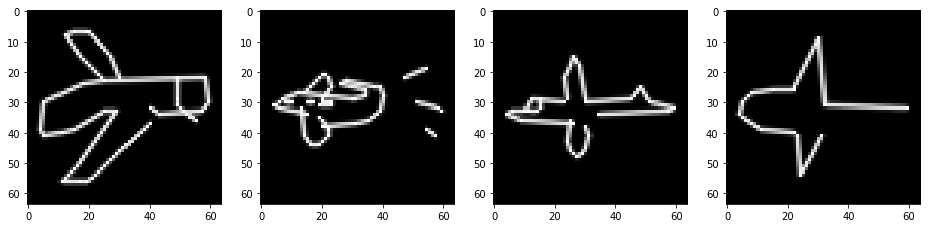

In [60]:
draw_a_batch(train_batch)

In [61]:
train_batch_2 = ImageBatchGenerator(class_array=class_array,
                                  full_df=df,
                                  datasplit_id=train_id,
                                  split='train_set',
                                  batch_size=4, 
                                  augment=random_augment, 
                                  mode='simplified', 
                                  norm=normalize,
                                  shuffle=False)

1
1
2
5
4
p [[ 4 39]
 [59 30]
 [15  7]
 [11 56]]
q [[ 0 44]
 [57 26]
 [24 15]
 [13 49]]
[[[1537. 1530. 1525. ... 4770. 4885. 5002.]
  [1460. 1453. 1448. ... 4693. 4808. 4925.]
  [1385. 1378. 1373. ... 4618. 4733. 4850.]
  ...
  [ 500.  493.  488. ... 3733. 3848. 3965.]
  [ 545.  538.  533. ... 3778. 3893. 4010.]
  [ 592.  585.  580. ... 3825. 3940. 4057.]]

 [[4381. 4264. 4149. ...  904.  909.  916.]
  [4322. 4205. 4090. ...  845.  850.  857.]
  [4265. 4148. 4033. ...  788.  793.  800.]
  ...
  [4442. 4325. 4210. ...  965.  970.  977.]
  [4505. 4388. 4273. ... 1028. 1033. 1040.]
  [4570. 4453. 4338. ... 1093. 1098. 1105.]]

 [[ 274.  245.  218. ... 2165. 2258. 2353.]
  [ 261.  232.  205. ... 2152. 2245. 2340.]
  [ 250.  221.  194. ... 2141. 2234. 2329.]
  ...
  [3141. 3112. 3085. ... 5032. 5125. 5220.]
  [3250. 3221. 3194. ... 5141. 5234. 5329.]
  [3361. 3332. 3305. ... 5252. 5345. 5440.]]

 [[3257. 3236. 3217. ... 5636. 5737. 5840.]
  [3146. 3125. 3106. ... 5525. 5626. 5729.]
  [3037.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


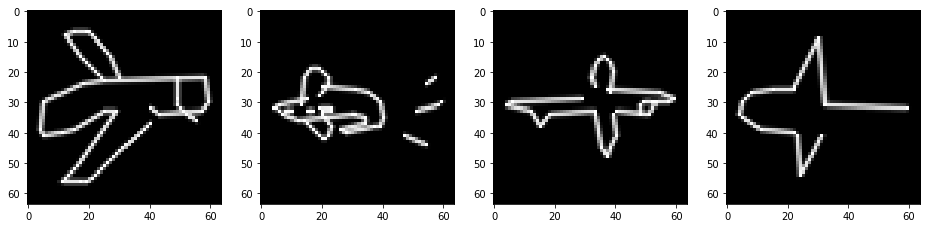

In [62]:
draw_a_batch(train_batch_2)

In [66]:
train_batch_2[0][0][2]

3
1
1
4
p [[ 4 34]
 [59 32]
 [30  9]
 [24 54]]
q [[ 1 36]
 [50 35]
 [32 13]
 [33 52]]
(4, 64, 64)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])